Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: MIT-0

# 4 - Use GraphRAG with Amazon Neptune to improve generative AI applications



In this notebook, we will learn how we can enhance the retrieval in a RAG application to leverage connected ideas, not just similar text, to provide more complete and explainable answers using a technique known as graph enhanced RAG or GraphRAG.   

Throughout the following exercises we will show you how to construct a chatbot application using Graph Enhanced RAG, which utilizes a graph within a RAG architecture to obtain more comprehensive, contextually relevant, and explainable responses from a RAG application.


By the end of this notebook we will have all the knowledge we need to complete updating our chatbot application's Graph Enhanced RAG (GraphRAG) functionality.

## What is Graph Enhanced RAG (GraphRAG), and why should I use it?

### What does a graph add to RAG applications?

Graphs are collection of entities - objects, events, and concepts – and relationships that describe a specific domain, the things in that domain, and the ways in which those things are connected or related. While vectors allow you to find relevant information that is similar in language, graphs allow you to find relevant information that may not necessarily be similar in language. 

Most RAG applications use embeddings to find relevant data based on similarity using vectors.  Vectors find relevant information using similarity within language by using a dense representation of data, commonly a text or image embedding, and mathematical closeness to determine similarity.  e.g. Sentences in a document that discuss similar locations/names/topics will be highly similar using a vector search. 

ex. *Zucchini* is similar to *summer squash* and *courgette*

In many situations vector search works very well, **however sometimes the most relevant information to answer a question may be the most connected ideas, not the most similar text**.  In situations such as where relevant information is distributed across many documents, requires looking at similar ideas, or requires high level summarization tend to be difficult for vector based solutions.  These sorts of questions require looking at shared connections and ideas, not just similar text.

Graphs represent entities, concepts, and interactions using connections, which allows graph searches to find relevant information based on connected ideas, not just language.  Graphs find relevant information based on these connected ideas and those that are most closely connected are the most similar.  e.g. Entities/concepts and interactions will be highly connected using a graph search.

ex. Chris Hemsworth and Tom Hiddleston are related because they’ve starred in multiple movies together

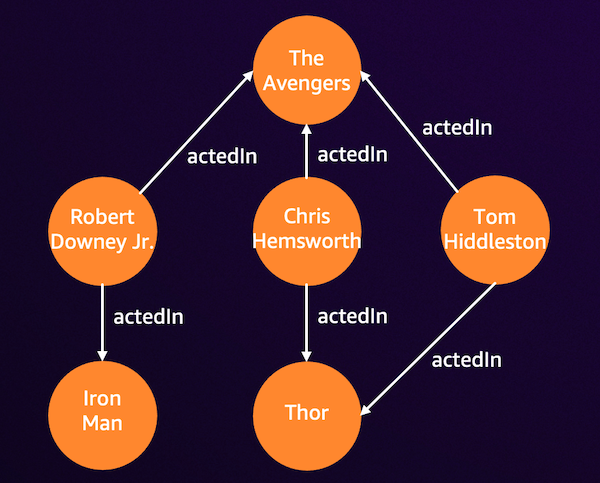

<div class="alert alert-success">
    <strong>🔑 Key Concept</strong><br /><hr>
It is important to understand that the choice here is not either vectors or graphs, they can be used independently in conjunction with each other to provide the most relevant results.  In fact, many more complex applications will route different queries to a vector search, a graph search, or a hybrid search based on the complexity and intent of the questions being asked.
<div>

<div class="alert alert-block alert-warning"> 
<details>
    <summary>💡  <b><i>Click here to look at an example of how graph enhanced RAG works</i></b></summary>

 



#### Example Corp's Quarterly Financial Statement

Let's take a look at an example to better understand how this works.  In this example we will be looking at a fictitious quarterly report for a company called `Example Corp`.  Example Corp's quarterly report contained four paragraphs:

* Paragraph 1 discussed how "Example Corp sells widget"
* Paragraph 2 discussed that the "UK is the biggest widget market"
* Paragraph 3 discussed that the "Widgets are shipped from China to the UK"
* Paragraph 3 discussed that "UK ports are experiencing slowdowns"

Let's see what it would look like to answer the question  - "What is the outlook for widget sales in the UK?"

In a vector search, the most similar facts are likely to be that `"Example Corp sells widget"` and `"UK is the biggest widget market"` as these are the most similar in language.  Based on these facts it is likely that the LLM would answer...

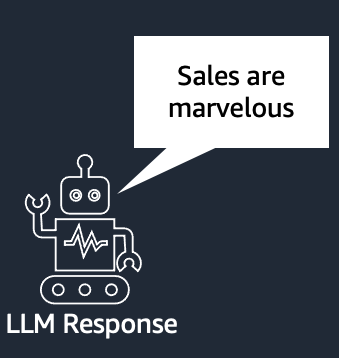
    
    However, when enhancing this information a graph search we look at how data is connected in addition to just language similarity.  In this example we could expect our knowledge graph to look like below.


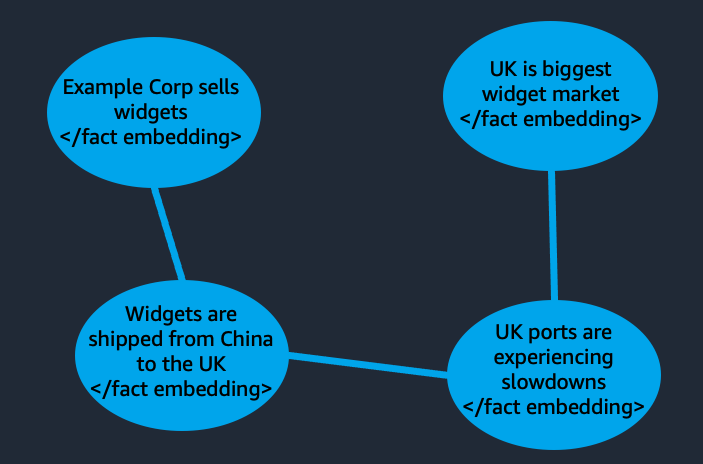

In this graph, we see that our facts are connected to relevant concepts or ideas.  When we ask our question, "What is the outlook for widget sales in the UK?", we would be able to start our graph traversal using a vector search, which would give us to the "Example Corp sells widget" and "UK is the biggest widget market" nodes.  From there we search their connections to find the other relevant facts that we want to consider.


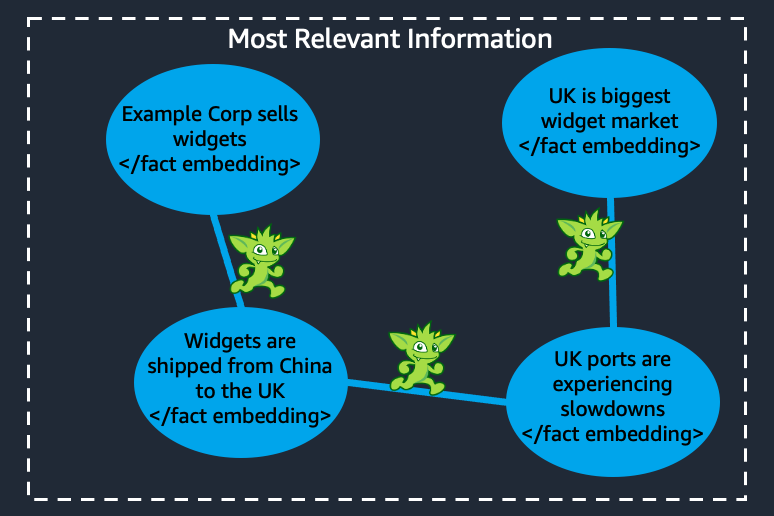

After our graph search we will find all 4 of the relevant facts:

* "Example Corp sells widget"
* "UK is the biggest widget market"
* "Widgets are shipped from China to the UK"
* "UK ports are experiencing slowdowns"

Based on these facts it is likely that the LLM would answer...

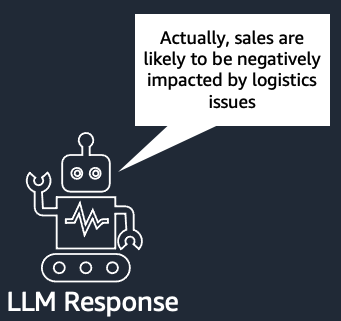
    </details>
</div>

Enhancing our vector query with a graph search provided us with more relevant information that allowed us to provide a more complete and relevant response.  Given that graphs are a natural way for users to think about information, this example also shows how graphs provide an enhanced degree of explainability for why these relevant facts were chosen.


<div class="alert alert-success">
    <strong>🔑 Key Concept</strong><br /><hr>
    It is important to understand that explainability in the context of Graph Enhanced RAG refers to the explainability of the relevant facts used as part of the input context, not the generated response from the LLM.  Once facts are provided to the LLM they cannot be directly mapped to the generated response.  
<div>


## Imports & Setup

The examples that follow are built using a few classes provided by LlamaIndex. We first need to import them. We will also pull some configuration information from the notebook and get the graph identifier for our Neptune Analytics graph for later use.

In [ ]:
%pip install -qqq llama-index==0.11.16 llama-index-llms-bedrock llama-index-graph-stores-neptune llama-index-embeddings-bedrock llama-index-readers-file nest-asyncio

<div class="alert alert-warning">
<strong>⚠️ Notice</strong><hr>
    
If a <code>Note</code> or <code>Error</code> message appears after installing these packages, you can safely ignore these version incompatabilities and/or message to restart the notebook kernel.
</div>

In [ ]:
# Configure LlamaIndex code
from llama_index.llms.bedrock import Bedrock
from llama_index.embeddings.bedrock import BedrockEmbedding
from llama_index.core import (
    SimpleDirectoryReader,
    PropertyGraphIndex,
    load_index_from_storage,
    StorageContext,
    Settings,
)

from llama_index.core import Settings
from llama_index.graph_stores.neptune import NeptuneAnalyticsPropertyGraphStore
from IPython.display import display

# Retrieve the configuration information for the notebook
import graph_notebook as gn
config = gn.configuration.get_config.get_config()
host = config.host.split('.')[0]

# Set environment variable for host for Streamlit App
import os
os.environ["HOST"] = host

# Setup nest to allow for reusing the event loop by LlamaIndex
# This is a required step when running in a Jupyter Notebook
import nest_asyncio
nest_asyncio.apply()

## Removing all Data
Running the cell below will remove all data from the current graph so that we can start with a clean graph to build our graph enhanced RAG application

In [ ]:
%%oc
MATCH (n) DETACH DELETE n

### Connect to the graph containing the data we want to query

Next, we'll need to configure a place to store our graph. The LlamaIndex integration with Neptune supports both Neptune Database and Neptune Analytics as a graph store. Since we will be using Neptune Analytics as a vector store, we will also use it as a graph store for convenience. 

In [ ]:
graph_store = NeptuneAnalyticsPropertyGraphStore(
    graph_identifier = host
)

print(graph_store)

### The LLM we want to use today

In this notebook we will be using the Claude V3 Sonnet Large Language Model supported by Amazon Bedrock for our LLM and Amazon Titan v2 for generating our embeddings.  For graph enhanced RAG applications we require two LLMs, one to handle question processing and response generation, in this notebook we will use Claude V3 Sonnet, and the second to create an embedding of the question for use as part of our vector search, in this case we will use Titan v2.

Now let's setup our models and set them as part of LlamaIndex's global `Settings` class.

In [ ]:
model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'
llm = Bedrock(model=model_id)

Settings.llm = llm

embed_model = BedrockEmbedding(model_name="amazon.titan-embed-text-v2:0", additional_kwargs={"dimensions": 256})
Settings.embed_model = embed_model
print(llm)

## Using LlamaIndex and Amazon Bedrock to Index a Document


Now that we have gone through the basics setup let's begin by indexing our first document.  Ingesting data into an index consists of three main steps:

1. Loading the data
2. Transforming the data
3. Indexing and storing the data

For this example we are going to use a fictitious document for `Example Corp` that contains an FAQ of the corporate requirements for SBOM data.  

Please take a moment view the file [here](https://aws-neptune-customer-samples-us-east-1.s3.amazonaws.com/workshops/building_genai_apps_using_neptune/data/Example+Corp+Software+Bill+of+Material.pdf).

Since we are using a fictitious (and internal) document we can be confident that our LLM has never seen this before so we know that any results containing this information are coming from our data, not the training data of the LLM.

### Loading Data

Let's start by downloading our internal document to our machine so that we can index it.

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Write a command to copy the directory located at <code>s3://aws-neptune-customer-samples-us-east-1/workshops/building_genai_apps_using_neptune/data/</code> into a <code>data/</code> directory located in the same folder as this notebook. 
</div>

In [ ]:
!aws s3 sync <INSERT YOUR CODE HERE> 

<div class="alert alert-block alert-warning"> 
<details>
    <summary>💡  <b><i>Click here for a hint!</i></b></summary>

Use the S3 sync command to copy the entire folder and its contents. https://docs.aws.amazon.com/cli/latest/reference/s3/sync.html
    
You can call AWS CLI commands directly from notebook cells using <code>!aws &lt;service&gt; &lt;command&gt</code>
    
</details>
</div>



<div class="alert alert-block alert-success"> 
<details>
    <summary>✅ <b><i>Click here to check your answer!</i></b></summary>

You can use the S3 sync command to copy the entire folder and its contents:
    
    
    
<code>!aws s3 sync s3://aws-neptune-customer-samples-us-east-1/workshops/building_genai_apps_using_neptune/data/ ./data</code>
    
</details>
</div>

Now that we have our document located on this machine we can load that document into a variable, called `documents`, that we will use as an input for our indexing operation.

LlamaIndex provides a variety of different data connectors for loading data from a variety of sources, see them [here](https://docs.llamaindex.ai/en/stable/understanding/loading/llamahub/) but in this case we are going to use the `SimpleDirectoryReader`.  This is the most straightforward connection which creates a `Document` object for each file in the provided directory, in our case we will get one object for our one file.  

In [ ]:
reader = SimpleDirectoryReader(input_dir="/home/ec2-user/SageMaker/Neptune/00-Workshop-Start-HERE/data/")
documents = reader.load_data()
print(documents)

### Transforming and storing data

Now that our data has been loaded into our `documents` object we need to process and transform that data for indexing.  In this case we are going to perform:

* Chunking - Breaking our document into smaller more manageable pieces
* Parsing - Take the document chunks and extracting out the key entities and relations
* Metadata extraction - We will then associate metadata, such as the parent document, with the chunks and entities
* Embedding - We will embed the entity and chunk information using Amazon Titan V2

This is one area where LlamaIndex does much of the heavy lifting for us.

Indexes have a `.from_documents()` method which accepts an array of Document objects and will perform the steps above on these documents.  LlamaIndex provides a variety of hooks to customize each of these steps but for this example we are going to use the defaults.

Once these steps are complete our data will be stored into our graph, as well as into several local JSON files that maintain state for the application.

**Note** - This may take some time to complete the extraction and indexing process.

In [ ]:
index = PropertyGraphIndex.from_documents(
        documents,
        property_graph_store=graph_store,
        embed_kg_nodes=True,
        show_progress=True,
)

<div class="alert alert-warning">
    
<details>
    <summary>
        <strong>⚠️ Warning</strong> - Click here if you see an <code>AccessDeniedException</code>
    </summary>
If you see an exception like this:
    
<code>AccessDeniedException: An error occurred (AccessDeniedException) when calling the InvokeModel operation: You don't have access to the model with the specified model ID.</code>
    
Please go back to the introduction and ensure that you have enabled access to our models (Titan Embeddings V2 and Anthropic Claude v3 Sonnet in Amazon Bedrock.

    </details>
</div>

Now that we have created a graph from our data, let's take a look at the data structure.

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Write an openCypher query to visualize the entire graph.
</div>

In [ ]:
%%oc

<YOUR QUERY HERE>

<div class="alert alert-block alert-warning"> 
<details>
    <summary>💡 <b><i>Click here for a hint!</i></b></summary>

Your openCypher query should return the `name` property for each `Component` label.  
    
If you need guidance on how to write openCypher queries please check out the tutorial linked below.
    
[openCypher Basic Read Queries](../04-Language-Tutorials/02-openCypher/01-Basic-Read-Queries.ipynb)
    
</details>
</div>



<div class="alert alert-block alert-success"> 
<details>
    <summary>✅ <b><i>Click here to check your answer!</i></b></summary>

The following query finds 100 paths in the graph. After running the query, be sure to click on the <b>Graph</b> tab to see the visualization.
    
```
MATCH p = ()-[]->()
RETURN p
LIMIT 100

```
    
</details>
</div>



When looking at our graph structure we can see that our index has generated a graph that consists mainly of `Chunk` nodes that are connected to `__Entity` nodes with a `MENTIONS` edge denoting the parent-child relationship.  

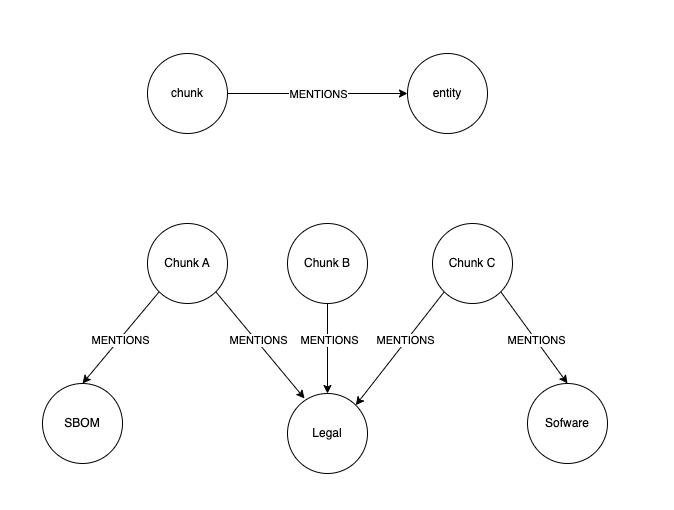

Within each node there is additional metadata about the entity, such as the `name` and in certain cases additional edges are created between `__Entity` nodes that represent relationships between those nodes.  Each `__Entity` node has several additional labels associated with them as well.  These are changed to more detailed categorizations if you use other features of the PropertyGraphIndex, such as schema driven extraction, which are outside of the scope of this workshop.

### Querying our Graph Enhanced RAG

Now we are ready to begin querying our RAG application.  In this notebook we will be focusing on the process of running graph enhanced RAG queries.  If you want to see how the results of a graph enhanced RAG application compares to a vector base RAG query this functionality is available in our demo application.

First, we can query and send only the values to the LLM. Using the [query engine](https://docs.llamaindex.ai/en/stable/module_guides/deploying/query_engine/#concept) will ensure that the response returned is in natural language format.

In [ ]:
query_engine = index.as_query_engine(
    include_text=True,
)
resp = query_engine.query("Where do I need to store SBOM data?")
print(resp)

LlamaIndex also provides an ability to retrieve just the data in an unsummarized format by using a retriever.  

Using a retriever, let's return the raw nodes themselves.

In [ ]:
query_retriever = index.as_retriever(
    include_text=True,
)
resp = query_engine.retrieve("Where do I need to store SBOM data?")
print(resp)

## Loading data from an existing index

To save time, we have run the entity extraction process for you on 3 different documents (https://github.com/aws-samples/amazon-neptune-generative-ai-samples/tree/main/solutions/sbom-chatbot/data/kg_enhanced_rag) and pre-generated the corresponding files needed to load the graph data into your Neptune Analytics graph.

### Clear and reload data from existing index

Now we'll load data that includes our original graph plus entities extracted from multiple other documents. We've done the extraction on your behalf to save time.

In [ ]:
%%oc
MATCH (n) DETACH DELETE n
WITH collect(n) as cnt
CALL neptune.load({format: 'csv', source: 's3://aws-neptune-customer-samples-us-west-2/workshops/building_genai_apps_using_neptune/sbom_data/',format: 'csv'})
YIELD totalRecords
RETURN totalRecords

### Get the on-disk data

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Write a command to copy the directory located at <code>s3://aws-neptune-customer-samples-us-east-1/workshops/building_genai_apps_using_neptune/persist/</code> into a <code>persist/</code> directory located in the same folder as this notebook. 
</div>

In [ ]:
!aws s3 sync <YOUR CODE HERE>

<div class="alert alert-block alert-success"> 
<details>
    <summary>✅ <b><i>Click here to check your answer!</i></b></summary>

You can use the S3 sync command to copy the entire folder and its contents:
    
    
    
<code>!aws s3 sync s3://aws-neptune-customer-samples-us-east-1/workshops/building_genai_apps_using_neptune/persist/ ./persist/</code>
    
</details>
</div>



### Create the Storage Context

When loading data from an existing index, such as on an application restart, we need to leverage a core abstraction of LlamaIndex known as a `StorageContext`.  A `StorageContext` contains the references to both the state files stored on disk as well as any persistent database storage, which is our Amazon Neptune `graph_store` object.

To load data, user simply needs to re-create the storage context using the same configuration as when they persisted the data.

In [ ]:
storage_context = StorageContext.from_defaults(
    persist_dir="/home/ec2-user/SageMaker/Neptune/00-Workshop-Start-HERE/persist/",
    property_graph_store=graph_store,
)

### Load our index

Now that we have our `StorageContext` we can load data using a helper function of LlamaIndex `load_index_from_storage`.  

In [ ]:
index = load_index_from_storage(storage_context)

Once we run this, which may take a few moments, we have restored our data from our persisted index.

## Querying our application

Now that we have our index loaded, let's query it as we did previously

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Create a `query_engine` from our recreated index.
</div>

In [ ]:
query_engine = # Create a query_engine for your index

<div class="alert alert-block alert-success"> 
<details>
    <summary>✅ <b><i>Click here to check your answer!</i></b></summary>

```
query_engine = index.as_query_engine(
    include_text=True,
) 
```
    
</details>
</div>



Now we are ready to query our graph using our query engine.

In [ ]:
resp = query_engine.query("Where do I need to store SBOM data?")
print(resp)

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Try different queries relating to the SBOM data in the graph and see how the index responds.  Some suggested questions:

* "What are best practices for SBOM data at Example Corp?"
* "My application uses a managed service, what are my requirements around having SBOM data for applications using this service?"
    
</div>

In [ ]:
try:
    resp = query_engine.query("")
    print(resp)
except Exception as e:
    print(e)

## Putting it all together

Now that we have all the pieces, we can combine them to produce a question and answer chatbot that hides the complexity that leverages graph enhanced RAG.

For this next section we are going to be modifying an incomplete version of our chatbot application to have it function for open domain question and answering.

In Jupyter, navigate to the `app` subfolder and click on the file `GraphEnhancedRAG.py` to edit it.

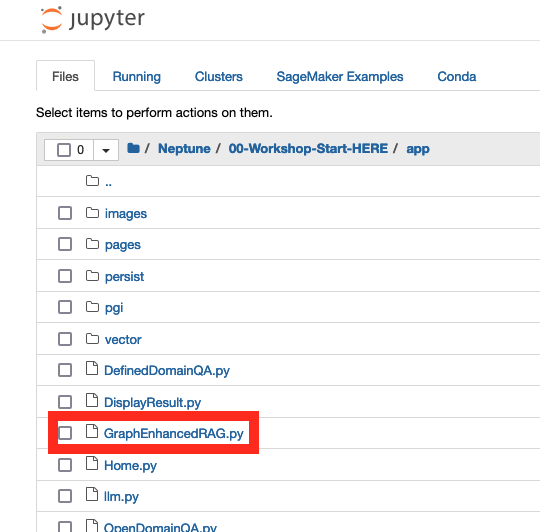

Once you have loaded that file you will need to update the code block below to create the storage context as well as to recreate the index from disk

```
# UPDATE THE CODE TO CREATE THE STORAGE CONTEXT AND LOAD THE INDEX
#         storage_context = 
#         self.pg_index = 
```

**Note** Within the directory structure of the application the local PropertyGraphIndex files are being stored in the `app/persist/pgi` directory.

<div class="alert alert-block alert-success"> 
<details>
    <summary>✏️ <b><i>Click here to check your answer</i></b></summary>

```
        storage_context = StorageContext.from_defaults(
            persist_dir=PERSIST_DIR + "/pgi",
            property_graph_store=self.index.property_graph_store,
        )
        self.pg_index = load_index_from_storage(storage_context)
```

</details>
</div>

Once you have created the index in the steps above you need to uncomment the following lines from the `__init__()` method so that our query engine is created correctly.

```
        # self.pg_query_engine = self.pg_index.as_query_engine(
        #     include_text=True,
        # )
```

Once you have made these changes you can proceed on to the cells below, which will run our Streamlit application locally so you can test out your application.  Once it is running please click on the "Click here to open the sample application" link to open a new browser tab pointing to your running application.

In [ ]:
%pip install -qqq -r ./app/requirements.txt jupyter-server-proxy jupyter-rsession-proxy

<div class="alert alert-warning">
<strong>⚠️ Notice</strong><hr>
    
If a <code>Note</code> or <code>Error</code> message appears after installing these packages, you can safely ignore these version incompatabilities and/or message to restart the notebook kernel.
</div>

In [ ]:
import subprocess

# Fetch the CloudFormation stack output
output_value = subprocess.check_output(
    ["aws", "cloudformation", "describe-stacks",
     "--stack-name", "workshop",
     "--query", "Stacks[0].Outputs[?OutputKey==`NotebookInstance`].OutputValue | [0]",
     "--output", "text"]
).decode().strip()
output_value += "proxy/8501/Graph_Enhanced_RAG_(GraphRAG)"

# Display the clickable link to the chat app
from IPython.display import Markdown

display(Markdown(f"<a href={output_value} target=\"_blank\">Click here to open the sample application</a>"))

!streamlit run ./app/Home.py --browser.gatherUsageStats false --browser.serverAddress 0.0.0.0 > /dev/null

<div class="alert alert-block alert-danger"> 
<strong>🛑</strong> You must stop the cell execution manually using the stop button on the control bar before moving on to the rest of this notebook.
</div>

## Summary

In this section we have demonstrated how you can use a graph in conjunction with vectors to provide more complete, comprehensive, and explainable information during the retrieval phase of a RAG application.  Graphs provide relevant information based on connections and conceptual similarity.  When combined with vector similarity we can answer questions that require:

* Comprehensive, contextual answers across complex domains.
* Integration of information from multiple documents.
* Advanced reasoning about connections between entity relationships and contexts.
* Explainability of relevant information as graphs are easier to understand and can be audited and explained. 

Graph enhanced RAG is a fast moving area of development and techniques for improvement are constantly evolving.  In this section we just scratched the surface of the options and configurations that can be used to customize these sorts of applications to suit real world applications such as customer support, content recommendation, and R&D applications.

## Next Steps
We have completed the main sections on this notebook and have completed building out our basic application.  You have now completed this workshop so you can either continue on with the optional sections or end you session.  Thank you.

---
# Optional - Adding documents to an existing index

One common requirement for applications is the need to add data to an existing graph as new documents become available.  In this case we will have created a supplement to our earlier FAQ document for `Example Corp`.  

You can view our supplement document [here](https://aws-neptune-customer-samples-us-east-1.s3.amazonaws.com/workshops/building_genai_apps_using_neptune/supplement/Example+Corp+Supplement.pdf).

Before we get started let's run a query to see yhe number of nodes in our graph.  Once we add our new document we will run it again and compare the results.

In [ ]:
%%oc

CALL neptune.graph.pg_info()

Now that we have our baseline answer we are ready to index our new document.

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Write a command to copy the directory located at <code>s3://aws-neptune-customer-samples-us-east-1/workshops/building_genai_apps_using_neptune/supplement/</code> into a <code>supplement/</code> directory located in the same folder as this notebook. 
</div>

In [ ]:
!aws s3 sync <YOUR CODE HERE>

<div class="alert alert-block alert-success"> 
<details>
    <summary>✅ <b><i>Click here to check your answer!</i></b></summary>

You can use the S3 sync command to copy the entire folder and its contents:
    
    
    
<code>!aws s3 sync s3://aws-neptune-customer-samples-us-east-1/workshops/building_genai_apps_using_neptune/supplement/ ./supplement</code>
    
</details>
</div>

To add this new document to our index we follow a similar process as we did when we indexed our single document.  We start by first loading the document from our directory.

In [ ]:
reader = SimpleDirectoryReader(input_dir="supplement/")
documents = reader.load_data()

Now that we have our new document loaded we use the `insert` method on our index to add this document to the existing index, passing in our array of `Document` objects.  

In [ ]:
for doc in documents:
    index.insert(doc)

That's it, our new document has been added to our index.  Let's rerun our query and see how our response compares to the baseline.

In [ ]:
%%oc

CALL neptune.graph.pg_info()

By comparing the information returned from our procedure we can see that new nodes and edges have been added to our graph.  